# Memory experiment: Compute $ \langle \bar{0} | \bar{Z} | \bar{0} \rangle$ with the five-qubit code

In [1]:
from typing import List, Dict, Sequence
import itertools
import functools
import numpy as np
import cirq
import qiskit
import qiskit_ibm_runtime
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler

import stim
import stimcirq
import matplotlib.pyplot as plt

from mitiq import PauliString

from encoded.diagonalize import get_stabilizer_matrix_from_paulis, get_measurement_circuit, get_paulis_from_stabilizer_matrix

## Set parameters

In [2]:
n = 5                                   # Number of physical qubits
nshots = 100_000                        # Number of samples/shots
depths = np.arange(0, 340 + 1, 20)      # Number of X (NOT) gates to perform (each depth should be even to implement a noisy identity)
k = 1                                   # Number of logical qubits.

In [3]:
# Computer and qubits to use.
# Option 1: Use saved noise characteristics.
computer = qiskit_ibm_runtime.fake_provider.FakeKyiv()


# computer = AerSimulator()  # Noiseless simulator - use this for a sanity check to see all computed expectation values (physical and encoded) are 1.0.

# Option 2: Use noise characteristics from most recent calibration.
# service = qiskit_ibm_runtime.QiskitRuntimeService()  # This assumes a saved account.
# computer = service.backend("ibm_kyiv")
# computer = AerSimulator.from_backend(computer)

# See calibration data at https://quantum.ibm.com/services/resources to select good qubits.




layout = {
    1 : [3],
    5 : [3,4,5,15,22],
}


# layout = {
#     1 : [7],
#     5 : [7,8,9,16,26],
# }

## Helper functions

In [4]:
# Expectation of pauli on bitstring measured in diagonal basis.
def compute_expectation(
    pauli: cirq.PauliString,
    counts: Dict[str, int],
) -> float:
    if pauli is cirq.PauliString():
        return 1.0

    expectation = 0.0

    indices = [q.x for q in pauli.qubits]
    for key, value in counts.items():
        key = list(map(int, list(key[::-1])))
        expectation += (-1) ** sum([key[i] for i in indices]) * value

    return expectation / sum(counts.values())




def parity_check_matrix_to_stabilizers(matrix: np.ndarray) -> List[stim.PauliString]:
    num_rows, num_cols = matrix.shape
    assert num_cols % 2 == 0
    num_qubits = num_cols // 2

    matrix = matrix.astype(np.bool8)  # indicate the data isn't bit packed
    return [
        stim.PauliString.from_numpy(
            xs=matrix[row, :num_qubits],
            zs=matrix[row, num_qubits:],
        )
        for row in range(num_rows)
    ]


def stabilizers_to_encoder(stabilizers) -> stim.Circuit:
    
    tableau = stim.Tableau.from_stabilizers(
        stabilizers,
        allow_underconstrained=True,
    )
    return tableau.to_circuit(method='graph_state')



# Prepares logical |0> state on Steane Code
def encode_five(qreg: Sequence[cirq.Qid]) -> cirq.Circuit:
    a= stim.PauliString("+ZX_XZ")
    b=stim.PauliString("+XZZX_")
    c= stim.PauliString("+_XZZX")
    d=stim.PauliString("+X_XZZ")
    test_encoder1 = stabilizers_to_encoder([a,b,c ,d])
    circuit =stimcirq.stim_circuit_to_cirq_circuit(test_encoder1) 
    circuit.append(cirq.X.on_each(qreg))
    
    return circuit

def noisy_identity(qreg, depth):
    circuit = cirq.Circuit()
    if depth == 0:
        circuit.append(cirq.I.on_each(qreg))
    for _ in range(depth):
        circuit.append(cirq.X.on_each(qreg))
    return circuit

def strs_to_paulis(pauli_strs : List[str]) -> List[cirq.PauliString]:
    stab_list = []
    for stab_str in pauli_strs:
        stab_list.append(PauliString(stab_str)._pauli)
    return stab_list

def generate_stabilizer_elements(generators: List[cirq.PauliString]) -> List[cirq.PauliString]:
    elements = []
    for string in itertools.chain.from_iterable(itertools.combinations(generators, r) for r in range(len(generators) + 1)):
        elements.append(
            functools.reduce(lambda a, b: a * b, string, cirq.PauliString())
        )
    return elements

# For qiskit circuits
def get_active_qubits(circ):
    dag = qiskit.converters.circuit_to_dag(circ)
    active_qubits = [qubit for qubit in circ.qubits if qubit not in dag.idle_wires()]
    return active_qubits

def get_lst_ev(counts, observables, stabilizers):
    numerator = 0
    for obs in observables:
        numerator += compute_expectation(obs, counts) / len(observables)
    denominator = 0
    for stab in stabilizers:
        denominator += compute_expectation(stab, counts) / len(stabilizers)
    return float(np.real_if_close(numerator / denominator))

### Run unmitigated experiment

In [5]:
qreg = cirq.LineQubit.range(k)

unmit_evs = []
for depth in depths:
    circuit = noisy_identity(qreg, depth)

    circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())
    circuit.measure_active()
    # Compile to device.
    compiled_raw = qiskit.transpile(
        circuit, 
        backend=computer,
        initial_layout=layout[1],  # Hardcode n = 1 (i.e., no encoding) to get layout.
        routing_method="sabre",
        # scheduling_method="asap",
        optimization_level=0,
    )

    job = computer.run(compiled_raw, shots=nshots)
    counts = job.result().get_counts()
    ev = compute_expectation(PauliString("Z")._pauli, counts)

    unmit_evs.append(ev)
    print(ev)

0.99382
0.9906
0.98766
0.985
0.98052
0.97578
0.9742
0.9709
0.96608
0.96194
0.96124
0.95716
0.95328
0.94966
0.94684
0.9437
0.94096
0.93576


# Run encoded experiment

In [6]:
generator_strs = [
    "XZZXI",
    "IXZZX",
    "XIXZZ", 
    "ZXIXZ"
]

observable = PauliString("Z" * n)._pauli

qreg = cirq.LineQubit.range(n)

stabilizer_generators = strs_to_paulis(generator_strs)
stabilizer_matrix = get_stabilizer_matrix_from_paulis(stabilizer_generators, qreg)
measurement_circuit, transformed_matrix = get_measurement_circuit(stabilizer_matrix)

transformed_generators = get_paulis_from_stabilizer_matrix(transformed_matrix)
stabilizer_elements = generate_stabilizer_elements(transformed_generators)
# for stab in stabilizer_elements:
#     print(stab)

transformed_observable = observable.conjugated_by(measurement_circuit**-1)
observable_elements = [transformed_observable * stab for stab in stabilizer_elements]
for obs in observable_elements:
    print(obs)
print(measurement_circuit)


Z(q(4))
Z(q(0))*Z(q(4))
Z(q(1))*Z(q(4))
Z(q(2))
Z(q(3))
Z(q(0))*Z(q(1))*Z(q(4))
Z(q(0))*Z(q(2))
Z(q(0))*Z(q(3))
Z(q(1))*Z(q(2))
Z(q(1))*Z(q(3))
Z(q(2))*Z(q(3))*Z(q(4))
Z(q(0))*Z(q(1))*Z(q(2))
Z(q(0))*Z(q(1))*Z(q(3))
Z(q(0))*Z(q(2))*Z(q(3))*Z(q(4))
Z(q(1))*Z(q(2))*Z(q(3))*Z(q(4))
Z(q(0))*Z(q(1))*Z(q(2))*Z(q(3))*Z(q(4))
      ┌──┐                       ┌──┐
0: ────@─────────X───────@───@─────@────H───────────
       │         │       │   │     │
1: ────┼@────────┼───X───@───┼────@┼────@───H───────
       ││        │   │       │    ││    │
2: ────┼┼────@───@───┼───────@────@┼────┼───@───H───
       ││    │       │             │    │   │
3: ────X┼────X───@───@─────────────@────@───@───H───
        │        │
4: ─────X────────X──────────────────────────────────
      └──┘                       └──┘


In [7]:
from qiskit.circuit.library import Barrier
encoding = encode_five(qreg)

encoding = qiskit.QuantumCircuit.from_qasm_str(encoding.to_qasm())

measurement = qiskit.QuantumCircuit.from_qasm_str(measurement_circuit.to_qasm())

circ_full = encoding.compose(
        Barrier(n, label="encoding"), get_active_qubits(encoding)
    ).compose(Barrier(n, label="measurement"), get_active_qubits(encoding)
).compose(measurement)
circ_full.measure_active()

noiseless_compiled = qiskit.transpile(
    circ_full, 
    backend=computer,
    initial_layout=layout[n],
    routing_method="sabre",
    # scheduling_method="asap",
    optimization_level=3,
)

noiseless_compiled.draw(fold=-1, idle_wires=False)
# noiseless_compiled.count_ops()

global phase: π/4
                ┌─────────┐ ┌────┐   ┌────────┐  ┌──────┐┌─────────┐ ┌────┐          ┌──────┐┌──────────┐                 ┌──────┐   ┌────────┐                                                                                                        ┌──────┐┌─────────┐ ┌────┐          ┌──────┐┌──────────┐                 ┌──────┐   ┌────────┐   ┌────┐                                                                                                                                                                                                                                               encoding  measurement ┌──────────┐┌────┐┌──────────┐                                                                                             ┌──────┐┌─────────┐   ┌────┐  ┌────────┐                                                                                                                                                                                                     ┌──────┐  ┌─────────┐ ┌────┐          ┌──────┐┌──────────┐                 ┌──────┐┌────┐  ┌──────────┐  ┌────┐┌──────────┐                                                                                                                                      ┌──────┐┌──────────┐   ┌────┐   ┌──────────┐                                                                                                                            ┌──────┐   ┌─────────┐    ┌────┐             ┌──────┐┌──────────┐                 ┌──────┐  ┌────┐  ┌─────────────┐   ┌────┐  ┌──────────┐    ┌──────┐   ┌──────────┐   ┌────┐  ┌──────────────┐┌────┐┌──────────┐ ░       ┌─┐      
  q_0 -> 3 ─|0>─┤ Rz(π/2) ├─┤ √X ├───┤ Rz(-π) ├──┤1     ├┤ Rz(π/2) ├─┤ √X ├──────────┤1     ├┤ Rz(-π/2) ├─────────────────┤1     ├───┤ Rz(-π) ├────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├┤ Rz(π/2) ├─┤ √X ├──────────┤1     ├┤ Rz(-π/2) ├─────────────────┤1     ├───┤ Rz(-π) ├───┤ √X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────────░──────┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────┤1     ├┤ Rz(π/2) ├───┤ √X ├──┤ Rz(-π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├──┤ Rz(π/2) ├─┤ √X ├──────────┤1     ├┤ Rz(-π/2) ├─────────────────┤1     ├┤ √X ├──┤ Rz(3π/4) ├──┤ √X ├┤ Rz(-π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-π/4) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├───┤ Rz(π/2) ├────┤ √X ├─────────────┤1     ├┤ Rz(-π/2) ├─────────────────┤1     ├──┤ √X ├──┤ Rz(-2.5126) ├───┤ √X ├──┤ Rz(-π/2) ├────┤1     ├───┤ Rz(-π/2) ├───┤ √X ├──┤ Rz(-0.62898) ├┤ √X ├┤ Rz(-π/2) ├─░───────┤M├──────
                ├─────────┤ ├────┤   └────────┘  │  Ecr │├─────────┴┐├────┤┌────────┐│  Ecr │├─────────┬┘┌────┐┌─────────┐│  Ecr │┌──┴────────┴──┐┌────┐┌─────────┐┌──────┐  ┌─────────┐  ┌────┐┌─────────────┐┌──────┐ ┌────────┐ ┌────┐  ┌────────┐  │  Ecr │├─────────┴┐├────┤┌────────┐│  Ecr │├─────────┬┘┌────┐┌─────────┐│  Ecr │┌──┴────────┴──┐├────┤┌──────┐┌─────────┐ ┌────┐┌──────────┐┌──────┐┌────────┐     ┌────┐    ┌─────────┐┌──────┐┌─────────┐ ┌────┐            ┌──────┐┌──────────┐                 ┌──────┐┌─────────┐   ┌────┐   ┌──────────┐┌──────┐┌──────────┐┌────┐┌──────────┐    ░           ░      ├─────────┬┘├────┤└┬────────┬┘┌──────┐┌─────────┐ ┌────┐          ┌──────┐┌──────────┐                 ┌──────┐┌─────────

In [8]:
print(computer)

### Add (noisy) identity to circuit and compute expectation values

In [9]:
mit_evs = []
for depth in depths:
    compiled = noiseless_compiled.copy_empty_like()
    for instruction in noiseless_compiled.data:
        if instruction.label == "measurement":
            for _ in range(depth):
                for q in get_active_qubits(compiled):
                    compiled.x(q)
        compiled.append(
            instruction, instruction.qubits
        )
        
    job = computer.run(
        compiled,
        shots=nshots,
    )
    counts = job.result().get_counts()
    ev = get_lst_ev(counts, observable_elements, stabilizer_elements)
    mit_evs.append(ev)
    print(ev)

0.9888329394032814
0.987572914024854
0.9853635050553684
0.9831032938398273
0.9803527954555161
0.9776153287322922
0.9728944359756097
0.9685374149659864
0.964494536603434
0.9631651132196939
0.9604750036651515
0.9539437226771751
0.9488559019900178
0.9434329632792486
0.9365330078615784
0.9291661956972233
0.9214322412362171
0.9187566811939809


### Make the measurement/diagonalization circuit noiseless and compute expectation values

In [10]:
from qiskit.circuit.library import UnitaryGate
from qiskit.transpiler import InstructionProperties

ideal_props = {
    (i,) : InstructionProperties(error=0.0, duration=0.0) for i in range(computer.num_qubits)
}

computer.target.add_instruction(UnitaryGate([[1, 0], [0, 1]]), ideal_props)
print(computer.target._gate_map['unitary'])

{(0,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (1,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (2,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (3,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (4,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (5,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (6,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (7,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (8,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (9,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (10,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (11,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (12,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (13,): InstructionProperties(duration=0.0, error=0.0, calibr

In [11]:
from qiskit.circuit.library import UnitaryGate
noiseless_compiled_perfect_measurment = noiseless_compiled.copy_empty_like()

enc = True
mea = False
for instruction in noiseless_compiled.data:
    # print(instruction)
    if not mea and instruction.label != "encoding" and instruction.label != "measurement":
        op = instruction
    elif instruction.label == "encoding":
        enc = False
        op = instruction
    elif instruction.label == "measurement":
        mea = True
        op = instruction
    elif instruction.matrix is None:
        op = instruction
    else:
        op = UnitaryGate(instruction.matrix, label="ideal_" + instruction.operation.name)
    noiseless_compiled_perfect_measurment.append(
        op, instruction.qubits
    )
# print(noiseless_compiled_perfect_measurment.count_ops())
noiseless_compiled_perfect_measurment.draw(fold=-1, idle_wires=False)

global phase: π/4
                ┌─────────┐ ┌────┐   ┌────────┐  ┌──────┐┌─────────┐ ┌────┐          ┌──────┐┌──────────┐                 ┌──────┐   ┌────────┐                                                                                                        ┌──────┐┌─────────┐ ┌────┐          ┌──────┐┌──────────┐                 ┌──────┐   ┌────────┐   ┌────┐                                                                                                                                                                                                                                               encoding  measurement ┌──────────┐┌──────────┐┌──────────┐                                                                                                                              ┌────────────┐┌──────────┐┌──────────┐ ┌──────────┐                                                                                                                                                                                                                                                           ┌────────────┐┌──────────┐┌──────────┐            ┌────────────┐┌──────────┐                        ┌────────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐                                                                                                                                                                  ┌────────────┐ ┌──────────┐ ┌──────────┐┌──────────┐                                                                                                                                                      ┌────────────┐┌──────────┐┌──────────┐            ┌────────────┐┌──────────┐                        ┌────────────┐┌──────────┐ ┌──────────┐ ┌──────────┐┌──────────┐┌────────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐ ░       ┌─┐      
  q_0 -> 3 ─|0>─┤ Rz(π/2) ├─┤ √X ├───┤ Rz(-π) ├──┤1     ├┤ Rz(π/2) ├─┤ √X ├──────────┤1     ├┤ Rz(-π/2) ├─────────────────┤1     ├───┤ Rz(-π) ├────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├┤ Rz(π/2) ├─┤ √X ├──────────┤1     ├┤ Rz(-π/2) ├─────────────────┤1     ├───┤ Rz(-π) ├───┤ √X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────────░──────┤ ideal_rz ├┤ ideal_sx ├┤ ideal_rz ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1           ├┤ ideal_rz ├┤ ideal_sx ├─┤ ideal_rz ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1           ├┤ ideal_rz ├┤ ideal_sx ├────────────┤1           ├┤ ideal_rz ├────────────────────────┤1           ├┤ ideal_sx ├┤ ideal_rz ├┤ ideal_sx ├┤ ideal_rz ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1           ├─┤ ideal_rz ├─┤ ideal_sx ├┤ ideal_rz ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1           ├┤ ideal_rz ├┤ ideal_sx ├────────────┤1           ├┤ ideal_rz ├────────────────────────┤1           ├┤ ideal_sx ├─┤ ideal_rz ├─┤ ideal_sx ├┤ ideal_rz ├┤1           ├┤ ideal_rz ├┤ ideal_sx ├┤ ideal_rz ├┤ ideal_sx ├┤ ideal_rz ├─░───────┤M├──────
                ├─────────┤ ├────┤   └────────┘  │  Ecr │├─────────┴┐├────┤┌────────┐│  Ecr │├─────────┬┘┌────┐┌─────────┐│  Ecr │┌──┴────────┴──┐┌────┐┌─────────┐┌──────┐  ┌─────────┐  ┌────┐┌─────────────┐┌──────┐ ┌────────┐ ┌────┐  ┌────────┐  │  Ecr │├─────────┴

In [12]:
mit_evs_im = []
for depth in depths:
    compiled = noiseless_compiled_perfect_measurment.copy_empty_like()
    for instruction in noiseless_compiled_perfect_measurment.data:
        if instruction.label == "measurement":
            for _ in range(depth):
                for q in get_active_qubits(compiled):
                    compiled.x(q)
        compiled.append(
            instruction, instruction.qubits
        )

    job = computer.run(
        compiled,
        shots=nshots,
    )
    counts = job.result().get_counts()
    ev = get_lst_ev(counts, observable_elements, stabilizer_elements)

    mit_evs_im.append(ev)
    print(ev)

0.9986184722815303
0.9982901644380918
0.9971644478471072
0.9973163167938932
0.9961364895891064
0.9948399202533129
0.9941229576392699
0.9933235113108669
0.9908398762788483
0.9889360820470321
0.9883710724942955
0.9865643886564391
0.9843387895494351
0.9800144972558765
0.9756336876533115
0.9730399216544734
0.9682923877526323
0.9670198007314917


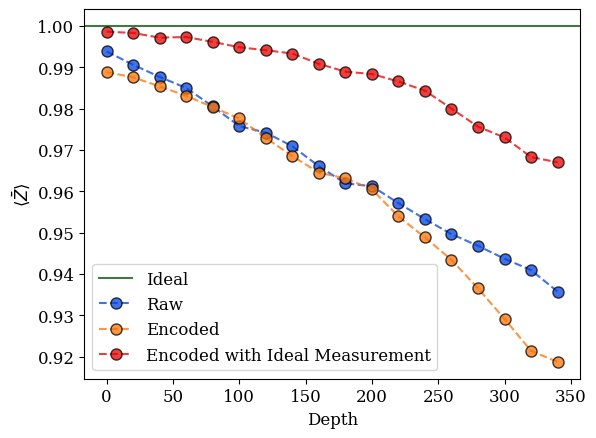

In [13]:
plt.rcParams.update({"font.family": "serif", "font.size": 12})
colors = ["xkcd:blue", "xkcd:orange", "xkcd:red"]
alpha: float = 0.75
stop: int = 20

# plt.title("Measuring $\\langle\\overline{Z}\\rangle$ on $|0\\rangle$ with Steane [[7,1,3]] Code")
plt.ylabel(r"$\langle \bar{Z} \rangle$")
plt.xlabel("Depth")
# plt.plot(depths[:stop], [1.0] * len(depths[:stop]), "--", label="Ideal")
plt.axhline(1.0, label="Ideal", alpha=0.75, color="xkcd:darkgreen")
plt.plot(depths[:stop], unmit_evs[:stop], "--o", color=colors[0], alpha=alpha, mec="black", ms=8, label="Raw")
plt.plot(depths[:stop], (mit_evs[:stop]), "--o", alpha=alpha, color=colors[1], mec="black", ms=8, label="Encoded")
plt.plot(depths[:stop], (mit_evs_im[:stop]), "--o", alpha=alpha, color=colors[2], mec="black", ms=8, label="Encoded with Ideal Measurement")
plt.legend()
plt.savefig(f"five_qubit_code_[[5,1,3]]_logical_zero_logical_z_{computer.name}.pdf")
plt.show()